# Analyzing Objective Functions and Optimization Methods in Classification Task

In this project I implemented various optimization methods and loss functions for classification tasks. By applying the different loss functions and optimization techniques across different datasets, I gained an understanding of the efficiency vs. accuracy tradeoff of each model, and under which conditions they thrive.

### Loss Functions:
1) **Hinge Loss**: Non-smooth: Use sub-gradient optimization 

2) **Hinge Loss** (Smooth Approximation): Use only optimization methods that only apply to smooth functions

3) **L2 Penalized Logistic Regression**: Use only optimization methods that only apply to smooth functions

### Optimization Methods:
i) Stochastic sub-gradient

ii) Stochastic gradient

iii) Mini-batch (sub-)gradient

iv) Stochastic average sub-gradient (SAG)

v) Stochastic average gradient (SAG)

vi) Gradient descent with Armijo line-search

vii) Acceleratd gradient with Armijo line-search



# Dataset and LIBSVM Instructions

LIBSVM package can be downloaded from here: https://www.csie.ntu.edu.tw/~cjlin/libsvm/#download. 
If the download is successful, you will have a folder with name: libsvm-3.24. This packed is required to load the datasets.
Enter the downloaded folder libsvm-3.24 through your terminal. 
Run make command to compile the package.

# Windows Users
Windows Users may have some issues with the package. An alternative approach is to install the windows binaries from here:
https://www.lfd.uci.edu/~gohlke/pythonlibs/#libsvm

# Required Libraries

In [8]:
# !pip install numpy, scipy, sys

## Load other useful modules

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from svmutil import *

# Datasets

The following three datasets are used:
    
1) a9a dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a 

2) news20.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#news20.binary

3) covtype.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#covtype.binary

### Training and Testing Data

All datasets above consist of training and testing data. I have split the training data into a training and dev set. I use an 80-20 split for all datasets

# Optimization problems

### Objective Functions

**1) Hinge-loss**
$$\mbox{minimize}_{x\in\mathbb{R}^d, \beta \in \mathbb{R}} \ \frac{1}{n} \sum_{i=1}^n \max \{0,1-b_i(a_i^Tx + \beta)\},$$
Where $a_i\in\mathbb{R}^d$ is the feature vector for sample $i$ and $b_i$ is the label of sample $i$. Note that this function is non-smooth.

**2) Hinge-loss Smooth Approximation**

$$
\psi_\mu(z) = 
\begin{cases}
0 & z\ge 1\\
(1-z)^2 & \mu < z < 1 \\
(1-\mu)^2 + 2(1-\mu)(\mu-z) & z \le \mu.
\end{cases}
$$


**3) L2-regularized logistic regression**
$$\mbox{minimize}_{x\in\mathbb{R}^d,\beta\in\mathbb{R}} \ \lambda \|x\|_2^2 + \frac{1}{n} \sum_{i=1}^n \log (1+ \exp(-b_i(a_i^Tx + \beta))).$$

# Utilities

In [10]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

def get_error(labels, pred_labels):
    return sum(abs(labels - pred_labels)) / len(labels)

def get_accuracy(labels, pred_labels):
    return 1 - .5*get_error(labels, pred_labels)

def my_experiment(A_train, A_test, b_train, b_test, methods, losses, max_iter, max_time, fontsize=15, linewidth=3, figsize=(12, 20)):
    accuracy = []
    for i, loss in enumerate(losses):
        plt.figure(1, figsize=figsize)
        plt.subplot(len(losses), 1, i+1)
        for method in methods:
            algorithm = method(loss)
            _, _, runtime, fvalues = algorithm.fit(A_train, b_train, max_iter = max_iter, max_time = max_time, return_fvalues = True)
            times = np.linspace(0, runtime, len(fvalues))
            plt.plot(times, fvalues, label=str(algorithm), linewidth=linewidth)
            plt.legend(fontsize=fontsize)
            plt.xlabel('Running time (sec)', fontsize=fontsize)
            plt.ylabel('Objective', fontsize=fontsize)
        plt.title(f'{str(loss)}', fontsize=fontsize*1.2)
        plt.show()

# Objective Functions

In [11]:
class LogisticLoss(object):
    
    def __init__(self, lambda_):
        self.lambda_ = lambda_
    
    def __str__(self):
        return 'L2-norm logistic loss'
    
    def get_fvalue(self, A, b, x, beta):
        return self.lambda_*sum(x**2)+sum(np.log(1+np.exp(-b*(A@x+beta))))/A.shape[0]
        
    def get_gradient(self, A, b, x, beta):
        return (lambda t,c: (2*self.lambda_*x - A.T@(b*t)/c, sum(-b*t)/c))(1/(1+np.exp(b*(A@x+beta))), A.shape[0])
    
    def predict(self, A, x, beta):
        return 2*(1+np.exp(-beta-A@x)<2)-1

    
class HingeLoss(object):
    
    def __str__(self):
        return 'Hinge loss'
    
    def get_fvalue(self, A, b, x, beta):
        return (lambda v: v@(v>0)/A.shape[0])(1-b*(A@x+beta))
    
    def get_gradient(self, A, b, x, beta):
        return (lambda v: (-A.T@v/A.shape[0], -np.mean(v)))((1>b*(A@x+beta))*b)
        
    def predict(self, A, x, beta):
        return 2*(A@x>-beta)-1

    
class HingeLossSmoothed(HingeLoss):
    
    def __init__(self, mu):
        self.mu = mu
    
    def __str__(self):
        return 'Hinge loss smoothed'
    
    def get_fvalue(self, A, b, x, beta):
        return (lambda z,mu: (1-mu)*(z<=mu)@(1+mu-2*z)+(1>z)*(z>mu)@(1-z)**2)(b*(A@x+beta),self.mu)/A.shape[0]
    
    def get_gradient(self, A, b, x, beta):
        return (lambda c,z,mu: (c*((1>z)*(z>mu)*(z-1)-(z<=mu)*(1-mu))*b@A, c*(b*(z-1)*(1>z)@(z>mu)-b@(z<=mu)*(1-mu))))(2/A.shape[0], b*(A@x+beta), self.mu)

# Classifier (Interface)

In [12]:
class Classifier(object):
    
    def __init__(self, objective):
        self.objective = objective
                
    def fit(self, A_train, b_train, epsilon=1e-2, max_iter=2000, max_time = 20, return_fvalues = False):
        runtime = 0
        self.x, self.beta = np.zeros(A_train.shape[1]), 0
        fvalues = [self.objective.get_fvalue(A_train, b_train, self.x, self.beta)]
        for num_iter in range(max_iter):
            st = time.time()
            if not self.update(A_train, b_train, num_iter) or runtime >= max_time:
                break
            runtime += time.time() - st
            if return_fvalues:
                fvalues.append(self.objective.get_fvalue(A_train, b_train, self.x, self.beta))
        return self.x, self.beta, runtime, fvalues
    
    def predict(self, A_test):
        return self.objective.predict(A_test, self.x, self.beta)

# Full Gradient Methods

In [13]:
class GradientDescentLineSearch(Classifier):
    
    def __str__(self):
        return f'Gradient descent + armijo ({str(self.objective)})'
    
    def get_stepsize(self, A_train, b_train, gradient_x, gradient_beta):
        stepsize = 1.0
        gamma = 0.7
        fvalue_init = self.objective.get_fvalue(A_train, b_train, self.x, self.beta)
        gradient_norm = np.linalg.norm(gradient_x)**2 + np.linalg.norm(gradient_beta)**2
        while stepsize > 0:
            if self.objective.get_fvalue(A_train, b_train, self.x-stepsize*gradient_x, self.beta-stepsize*gradient_beta) < fvalue_init-stepsize*gamma*gradient_norm:
                break
            stepsize /= 2
        return stepsize
    
    def update(self, A_train, b_train, num_iter, min_stepsize = 1e-8):
        gradient_x, gradient_beta = self.objective.get_gradient(A_train, b_train, self.x, self.beta)
        stepsize = self.get_stepsize(A_train, b_train, gradient_x, gradient_beta)
        self.x, self.beta = self.x - stepsize*gradient_x, self.beta - stepsize*gradient_beta
        return stepsize > min_stepsize


class AcceleratedGradientDescent(GradientDescentLineSearch):
    
    def __str__(self):
        return f'Accelerated gradient descent + armijo ({str(self.objective)})'
    
    def swap(self):
        self.x, self.u = self.u, self.x
        self.beta, self.v = self.v, self.beta
    
    def update(self, A_train, b_train, num_iter, min_stepsize = 1e-8):
        if num_iter == 0:
            self.t, self.prev_t = 1, 1
            self.u, self.prev_x, self.v, self.prev_beta = self.x, self.x, self.beta, self.beta
        gradient_u, gradient_v = self.objective.get_gradient(A_train, b_train, self.u, self.v)
        self.swap()
        stepsize = self.get_stepsize(A_train, b_train, gradient_u, gradient_v)
        self.swap()
        self.prev_x, self.x = self.x, self.u - stepsize*gradient_u
        self.prev_beta, self.beta = self.beta, self.v - stepsize*gradient_v
        self.prev_t, self.t = self.t, .5*(1+np.sqrt(1+4*self.t**2))
        self.u = self.x+(self.prev_t-1)/self.t*(self.x-self.prev_x)
        self.v = self.beta+(self.prev_t-1)/self.t*(self.beta-self.prev_beta)
        return stepsize > min_stepsize

# Stochastic Methods

In [14]:
class StochasticGradientDescent(Classifier):
    
    def __str__(self):
        return f'Stochastic gradient descent ({str(self.objective)})'
    
    def sample(self, A_train, b_train):
        return (lambda idx:(A_train[idx], b_train[idx:idx+1]))(np.random.randint(A_train.shape[0]))

    def update(self, A_train, b_train, num_iter):
        A_sample, b_sample = self.sample(A_train, b_train)
        gradient_x, gradient_beta = self.objective.get_gradient(A_sample, b_sample, self.x, self.beta)
        stepsize = 1/np.sqrt(num_iter+1)
        self.x, self.beta = self.x-stepsize*gradient_x, self.beta-stepsize*gradient_beta
        return True

    
class BatchGradientDescent(StochasticGradientDescent):
    
    def __init__(self, objective, batch_size = 20):
        self.objective = objective
        self.batch_size = batch_size
    
    def __str__(self):
        return f'Batch gradient descent ({str(self.objective)})'
    
    def sample(self, A_train, b_train):
        return (lambda idx:(A_train[idx], b_train[idx]))(np.random.randint(A_train.shape[0], size=self.batch_size))
    

class StochasticAverageGradientDescent(StochasticGradientDescent):
    
    def __str__(self):
        return f'Stochastic average gradient descent ({str(self.objective)})'
    
    def update(self, A_train, b_train, num_iter):
        if num_iter%A_train.shape[0] == 0:
            self.reset(A_train, b_train)
        idx = np.random.randint(A_train.shape[0])
        A_sample, b_sample = self.sample(A_train, b_train)
        gradient_x, gradient_beta = self.objective.get_gradient(A_sample, b_sample, self.x, self.beta)
        prev_gradient_x, prev_gradient_beta = self.objective.get_gradient(A_sample, b_sample, self.init_x, self.init_beta)
        stepsize = 1/np.sqrt(num_iter+1)
        self.x = self.x-stepsize*(gradient_x-prev_gradient_x+self.init_gradient_x)
        self.beta = self.beta-stepsize*(gradient_beta-prev_gradient_beta+self.init_gradient_beta)
        return True
    
    def reset(self, A_train, b_train):
        self.init_x, self.init_beta = self.x, self.beta
        self.init_gradient_x, self.init_gradient_beta = self.objective.get_gradient(A_train, b_train, self.x, self.beta)

# Validation Error
$$
\frac{1}{t}\sum_{i\in\mbox{validation data}} \left| \ b_i^{\mbox{model}} - b_i^{\mbox{true}} \ \right|
$$
where $t$ is the number of samples in validation set. $b_i^{\mbox{true}}$ is the true label of the $i$-th sample. $b_i^{\mbox{model}}$ is the label of the $i$-th sample of the model.

# Predicted Labels
For hinge loss: $$b_i^{\mbox{model}}:= \mbox{sign}(a_i^Tx + \beta).$$

For logistic regression:
$$
b_i^{\mbox{model}}=
\begin{cases}
1 & \mbox{if } \frac{1}{1+e^{-(a_i^Tx + \beta)}} > 0.5\\
-1 & \mbox{otherwise}
\end{cases}
$$

*Logistic Regression formulae are different from typical cases due to -1, 1 labels, as opposed to traditional binary output*

# Parameter Tuning For Logistic Loss 

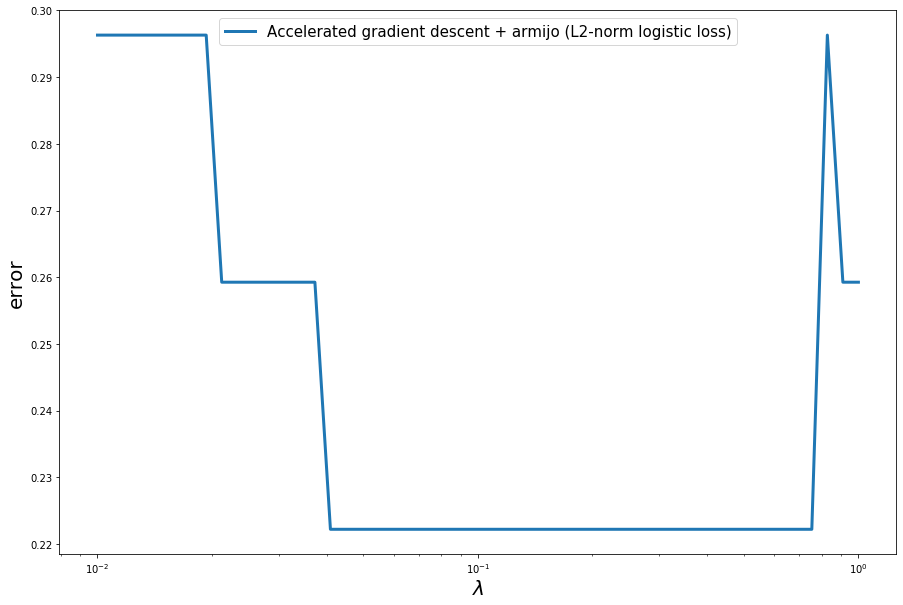

In [15]:
lambdas = np.logspace(-2, 0, 50)
errors = []
method = None
b_data, A_data = svm_read_problem('heart_scale', return_scipy = True) #Use heart scale file (small) for initial tuning
A_train, A_test, b_train, b_test = train_test_split(A_data, b_data, test_size=.2)
for l in lambdas:
    loss = LogisticLoss(l)
    method = AcceleratedGradientDescent(loss)
    method.fit(A_train, b_train, max_iter = 50)
    errors.append(get_error(b_test, method.predict(A_test)))
    
plt.figure(1, figsize=(15, 10))
plt.plot(lambdas, errors, label = str(method), linewidth=3)
plt.legend(fontsize=15)
plt.xlabel("$\lambda$", fontsize=20)
plt.ylabel("error", fontsize=20)
plt.xscale('log')
plt.show()

# Experiments

In [16]:
# Initialize Methods

full_gradient_methods = [
    GradientDescentLineSearch,
    AcceleratedGradientDescent,
]

batch_stochastic_gradient_methods = [
    BatchGradientDescent,
]

stochastic_gradient_methods = [
    StochasticGradientDescent,
    StochasticAverageGradientDescent,
]

all_methods = [
    GradientDescentLineSearch,
    AcceleratedGradientDescent,
    BatchGradientDescent,
    StochasticGradientDescent,
    StochasticAverageGradientDescent,
]

losses = [
    LogisticLoss(0.001),
    HingeLoss(),
    HingeLossSmoothed(.5)
]

## a9a

In [19]:
b_data, A_data = svm_read_problem('a9a', return_scipy=True)
A_train, A_test, b_train, b_test = train_test_split(A_data, b_data, test_size=.3)
print('Records, Feature', A_train.shape)

Records, Feature (22792, 123)


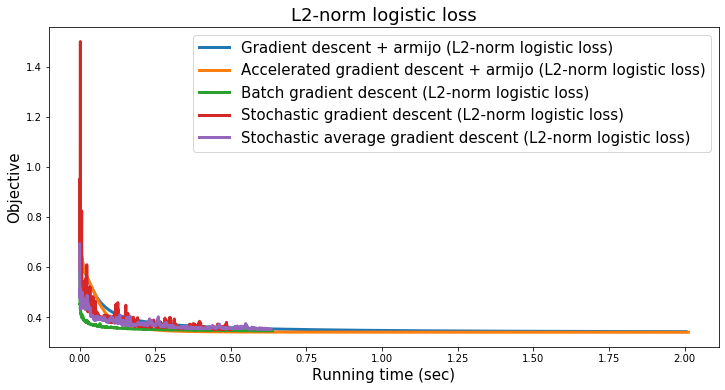

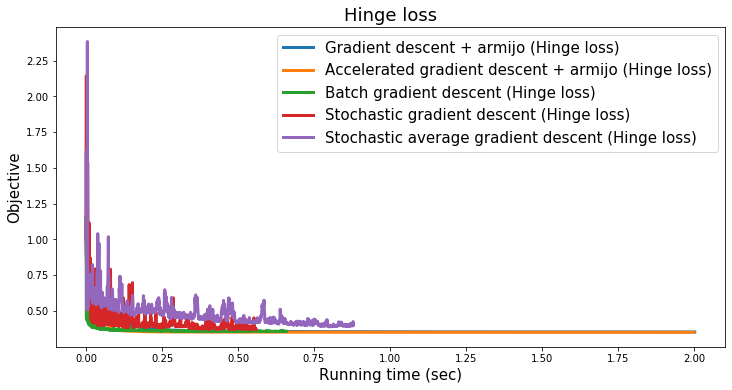

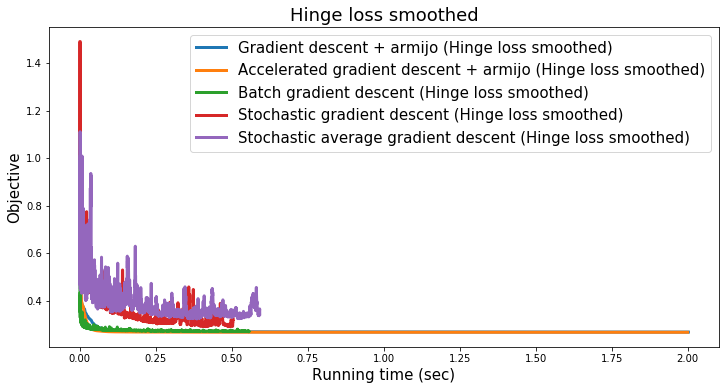

In [18]:
my_experiment(A_train, A_test, b_train, b_test, all_methods, losses, max_iter=2000, max_time = 2)

## news20.binary

In [23]:
path = 'news20.binary'
b_data, A_data = svm_read_problem(path, return_scipy=True)
A_train, A_test, b_train, b_test = train_test_split(A_data, b_data, test_size=.3)
print(f'min b: {min(b_data)}, max b: {max(b_data)}, (Records, Features): {A_data.shape}')

min b: -1.0, max b: 1.0, (Records, Features): (19996, 1355191)


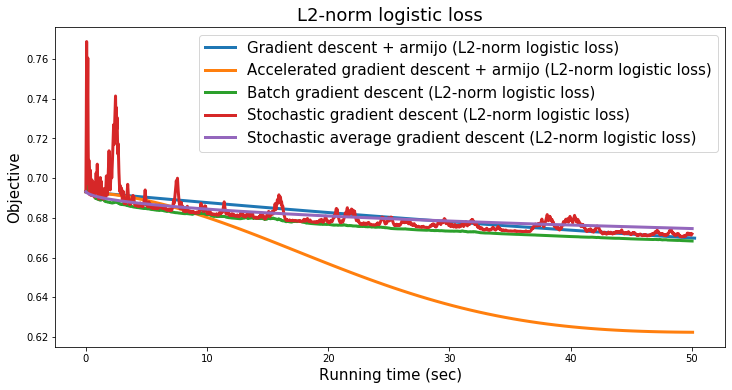

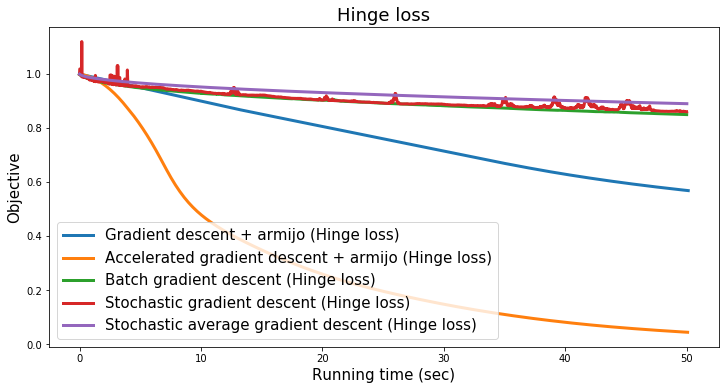

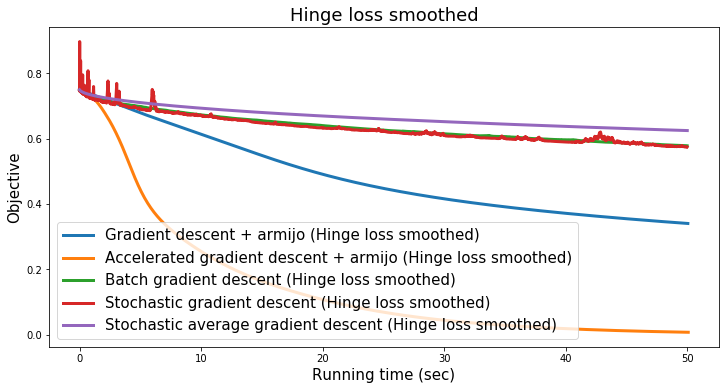

In [25]:
my_experiment(A_train, A_test, b_train, b_test, all_methods, losses, max_iter=200000, max_time=50)

## covtype.binary

In [29]:
path = 'covtype.libsvm.binary'
b_data, A_data = svm_read_problem(path, return_scipy=True)
b_data = b_data*2 - 3
A_data = normalize(A_data, axis = 1, norm = 'l1')
A_train, A_test, b_train, b_test = train_test_split(A_data, b_data, test_size = 0.8)
print(f'min b: {min(b_data)}, max b: {max(b_data)}, (Records, Features): {A_train.shape}')

min b: -1.0, max b: 1.0, (Records, Features): (116202, 54)


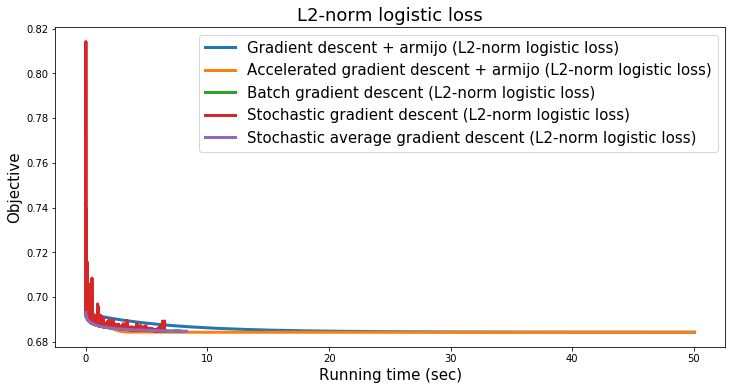

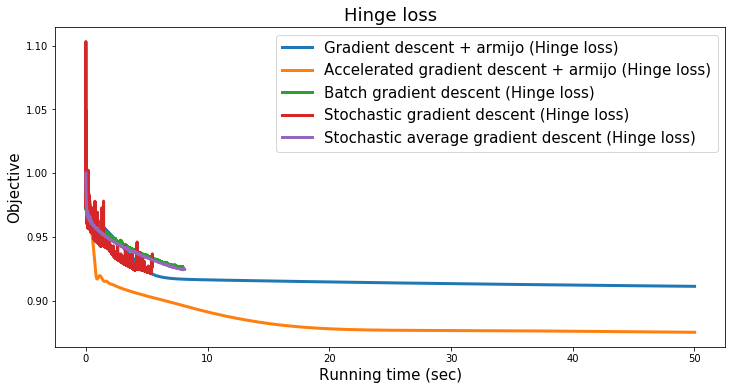

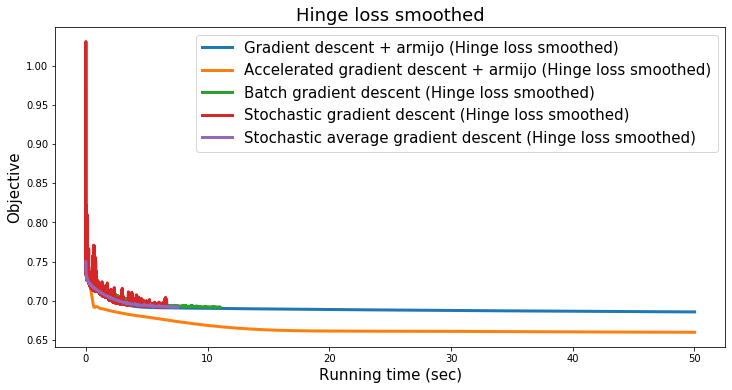

In [30]:
my_experiment(A_train, A_test, b_train, b_test, all_methods, losses, max_iter=20000, max_time=50)

In [ ]:
# Add accuracy scores to each algorithm / dataset...